In [1]:
import pandas as pd
df_plot = pd.read_csv("../data/merged_f1_data_clean.csv")
# Load pit stop data
pit_stops = pd.read_csv("../data/pit_stops.csv")

# Inspect the columns
print(pit_stops.columns)
pit_stops.head()

Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'milliseconds',
       'duration'],
      dtype='object')


,raceId,driverId,stop,lap,time,milliseconds,duration
0,841,153,1,1,17:05:23,26898,00:00:27
1,841,30,1,1,17:05:52,25021,00:00:25
2,841,17,1,11,17:20:48,23426,00:00:23
3,841,4,1,12,17:22:34,23251,00:00:23
4,841,13,1,13,17:24:10,23842,00:00:24


In [2]:
# Sum pit stop time per driver per race
total_pit_time = pit_stops.groupby(['raceId', 'driverId'])['milliseconds'].sum().reset_index()
total_pit_time.rename(columns={'milliseconds':'totalPitTime_ms'}, inplace=True)

# Convert to seconds for easier interpretation
total_pit_time['totalPitTime_s'] = total_pit_time['totalPitTime_ms'] / 1000
total_pit_time.head()


,raceId,driverId,totalPitTime_ms,totalPitTime_s
0,841,1,46426,46.426
1,841,2,48092,48.092
2,841,3,23716,23.716
3,841,4,72165,72.165
4,841,5,24865,24.865


In [3]:
# Merge pit stop times with race results
df_race_pit = pd.merge(df_plot, total_pit_time, how='left', left_on=['raceId','driverId'], right_on=['raceId','driverId'])

# Check merge
df_race_pit[['driverName','Grand Prix','year','finishPosition','gridPosition','totalPitTime_s']].head()


,driverName,Grand Prix,year,finishPosition,gridPosition,totalPitTime_s
0,Nico Rosberg,Australian Grand Prix,2014,1,3.0,48.004
1,Kevin Magnussen,Australian Grand Prix,2014,2,4.0,45.423
2,Jenson Button,Australian Grand Prix,2014,3,11.0,44.810
3,Fernando Alonso,Australian Grand Prix,2014,4,5.0,44.865
4,Valtteri Bottas,Australian Grand Prix,2014,5,10.0,58.038


In [4]:
print(df_plot.columns)
df_plot.head()

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'finishPosition', 'positionText', 'positionOrder', 'points', 'laps',
       'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'forename', 'surname', 'driverName',
       'gridPosition', 'year', 'Grand Prix'],
      dtype='object')


,resultId,raceId,driverId,constructorId,number,grid,finishPosition,positionText,positionOrder,points,...,rank,fastestLapTime,fastestLapSpeed,statusId,forename,surname,driverName,gridPosition,year,Grand Prix
0,22130,900,3,131,6,3,1,1,1,25.0,...,1,92.478,206.436,1,Nico,Rosberg,Nico Rosberg,3.0,2014,Australian Grand Prix
1,22131,900,825,1,20,4,2,2,2,18.0,...,6,93.066,205.131,1,Kevin,Magnussen,Kevin Magnussen,4.0,2014,Australian Grand Prix
2,22132,900,18,1,22,10,3,3,3,15.0,...,5,92.917,205.46,1,Jenson,Button,Jenson Button,11.0,2014,Australian Grand Prix
3,22133,900,4,6,14,5,4,4,4,12.0,...,7,93.186,204.867,1,Fernando,Alonso,Fernando Alonso,5.0,2014,Australian Grand Prix
4,22134,900,822,3,77,15,5,5,5,10.0,...,3,92.616,206.128,1,Valtteri,Bottas,Valtteri Bottas,10.0,2014,Australian Grand Prix


In [5]:
# Convert gridPosition and finishPosition to numeric
df_race_pit['gridPosition'] = pd.to_numeric(df_race_pit['gridPosition'], errors='coerce')
df_race_pit['finishPosition'] = pd.to_numeric(df_race_pit['finishPosition'], errors='coerce')

# Now compute positions gained/lost (ignores NaNs)
df_race_pit['positionsChange'] = df_race_pit['gridPosition'] - df_race_pit['finishPosition']

# Check result
df_race_pit[['driverName','gridPosition','finishPosition','positionsChange']].head(10)


,driverName,gridPosition,finishPosition,positionsChange
0,Nico Rosberg,3.0,1.0,2.0
1,Kevin Magnussen,4.0,2.0,2.0
2,Jenson Button,11.0,3.0,8.0
3,Fernando Alonso,5.0,4.0,1.0
4,Valtteri Bottas,10.0,5.0,5.0
5,Nico Hülkenberg,7.0,6.0,1.0
6,Kimi Räikkönen,12.0,7.0,5.0
7,Jean-Éric Vergne,6.0,8.0,-2.0
8,Daniil Kvyat,8.0,9.0,-1.0
9,Sergio Pérez,16.0,10.0,6.0


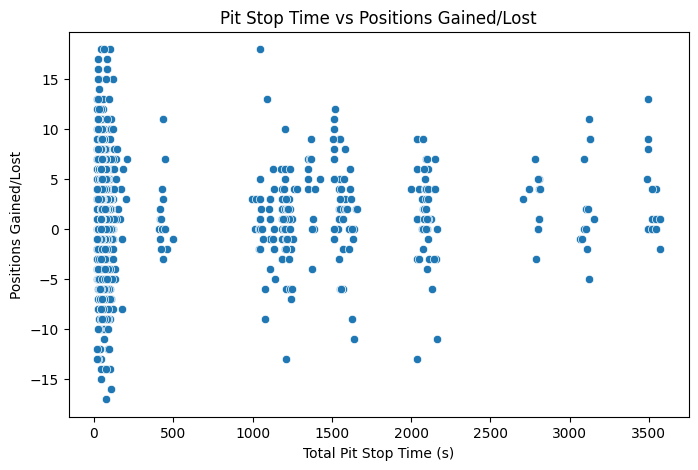

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(x='totalPitTime_s', y='positionsChange', data=df_race_pit)
plt.xlabel("Total Pit Stop Time (s)")
plt.ylabel("Positions Gained/Lost")
plt.title("Pit Stop Time vs Positions Gained/Lost")
plt.show()


In [7]:
# Approximate effect of pit stop on finishing position
df_race_pit['pitEffect'] = df_race_pit['positionsChange'] / df_race_pit['totalPitTime_s']
df_race_pit[['driverName','totalPitTime_s','positionsChange','pitEffect']].sort_values('pitEffect', ascending=False).head(10)


,driverName,totalPitTime_s,positionsChange,pitEffect
2450,Carlos Sainz,22.770,17.0,0.746596
1847,Lewis Hamilton,18.978,13.0,0.685004
1530,Sebastian Vettel,23.695,16.0,0.675248
3354,Esteban Ocon,19.019,12.0,0.630948
1988,Max Verstappen,23.446,13.0,0.554466
1431,Daniel Ricciardo,27.910,15.0,0.537442
177,Valtteri Bottas,29.104,15.0,0.515393
2512,Sergio Pérez,22.761,11.0,0.483283
2313,Daniil Kvyat,22.834,11.0,0.481738
1970,Daniel Ricciardo,22.864,11.0,0.481106


In [8]:
team_pit_effect = df_race_pit.groupby('constructorId')['pitEffect'].mean().sort_values(ascending=False)
print(team_pit_effect)


constructorId
211    0.088950
15     0.075702
207    0.072820
117    0.066368
206    0.053880
209    0.053121
51     0.048347
208    0.047010
10     0.046329
3      0.045750
4      0.039482
1      0.038846
9      0.031559
5      0.028395
214    0.027023
210    0.023691
213    0.019557
6      0.017221
131    0.009142
Name: pitEffect, dtype: float64


In [9]:
df_race_pit.to_csv("../data/merged_f1_data_with_pit.csv", index=False)